In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-analysis-on-movie-reviews/sampleSubmission.csv
/kaggle/input/sentiment-analysis-on-movie-reviews/train.tsv.zip
/kaggle/input/sentiment-analysis-on-movie-reviews/test.tsv.zip


**VANDER**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [3]:
# Read in data
# Read the .tsv file inside the .zip directly
df = pd.read_csv('/kaggle/input/sentiment-analysis-on-movie-reviews/train.tsv.zip', 
                 compression='zip', 
                 delimiter='\t')

# Print the first few rows of the DataFrame
print(df.head())

   PhraseId  SentenceId                                             Phrase  \
0         1           1  A series of escapades demonstrating the adage ...   
1         2           1  A series of escapades demonstrating the adage ...   
2         3           1                                           A series   
3         4           1                                                  A   
4         5           1                                             series   

   Sentiment  
0          1  
1          2  
2          2  
3          2  
4          2  


**EDA**

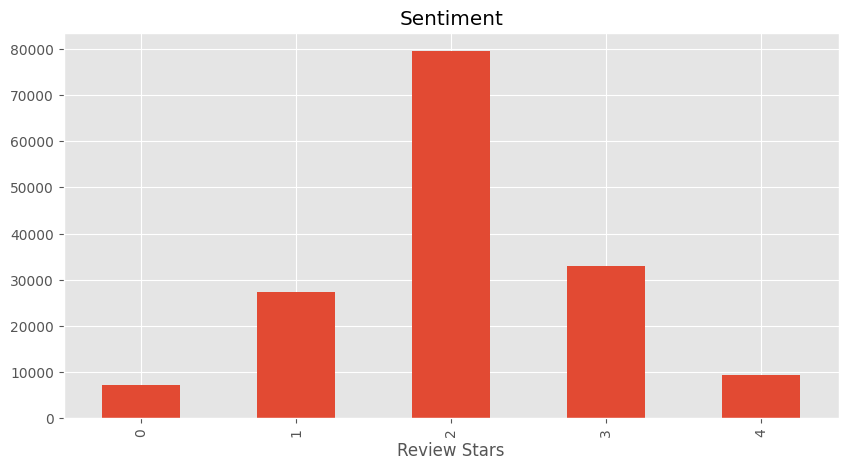

In [4]:
ax = df['Sentiment'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Sentiment',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

In [5]:
example = df['Phrase'][1]
print(example)

A series of escapades demonstrating the adage that what is good for the goose


In [6]:
tokens = nltk.word_tokenize(example)
tagged = nltk.pos_tag(tokens)
tokens[:10]
tagged[:10]

[('A', 'DT'),
 ('series', 'NN'),
 ('of', 'IN'),
 ('escapades', 'NNS'),
 ('demonstrating', 'VBG'),
 ('the', 'DT'),
 ('adage', 'NN'),
 ('that', 'IN'),
 ('what', 'WP'),
 ('is', 'VBZ')]

In [7]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  A/DT
  series/NN
  of/IN
  escapades/NNS
  demonstrating/VBG
  the/DT
  adage/NN
  that/IN
  what/WP
  is/VBZ
  good/JJ
  for/IN
  the/DT
  goose/NN)


In [8]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [9]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Phrase']
    myid = row[0]
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/156060 [00:00<?, ?it/s]

/tmp/ipykernel_24/2851595402.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  myid = row[0]


In [10]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'PhraseId'})
vaders = vaders.merge(df, on='PhraseId', how='left')

In [11]:
# Now we have sentiment score and metadata
vaders.head()

,PhraseId,neg,neu,pos,compound,SentenceId,Phrase,Sentiment
0,1,0.0,0.843,0.157,0.5579,1,A series of escapades demonstrating the adage ...,1
1,2,0.0,0.805,0.195,0.4404,1,A series of escapades demonstrating the adage ...,2
2,3,0.0,1.000,0.000,0.0000,1,A series,2
3,4,0.0,0.000,0.000,0.0000,1,A,2
4,5,0.0,1.000,0.000,0.0000,1,series,2


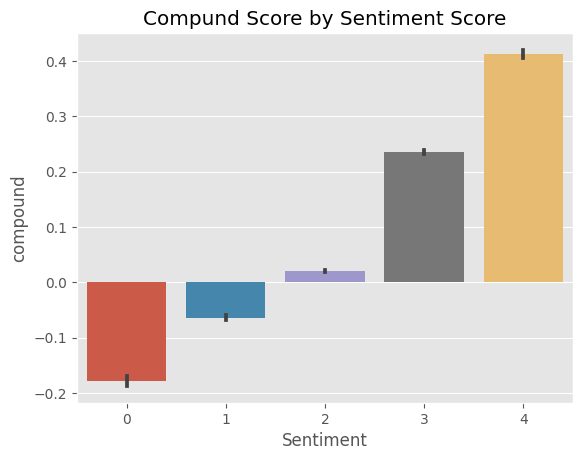

In [12]:
ax = sns.barplot(data=vaders, x='Sentiment', y='compound')
ax.set_title('Compund Score by Sentiment Score')
plt.show()

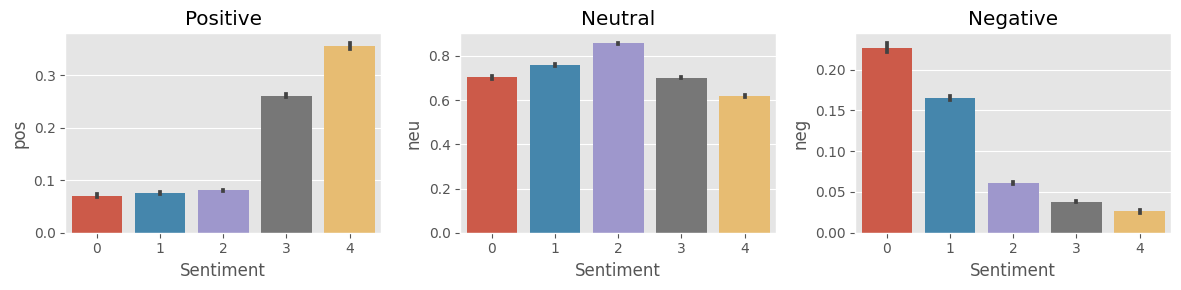

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Sentiment', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Sentiment', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Sentiment', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

In [14]:
test = pd.read_csv('/kaggle/input/sentiment-analysis-on-movie-reviews/test.tsv.zip', 
                 compression='zip', 
                 delimiter='\t')

# Print the first few rows of the DataFrame
print(test.head())

   PhraseId  SentenceId                                             Phrase
0    156061        8545  An intermittently pleasing but mostly routine ...
1    156062        8545  An intermittently pleasing but mostly routine ...
2    156063        8545                                                 An
3    156064        8545  intermittently pleasing but mostly routine effort
4    156065        8545         intermittently pleasing but mostly routine


In [15]:
non_string_rows = test[test['Phrase'].apply(lambda x: not isinstance(x, str))]
print(non_string_rows)

       PhraseId  SentenceId Phrase
15519    171580        9213    NaN


In [16]:
# Run the polarity score on the entire dataset
rest = {}
for i, row in tqdm(test.iterrows(), total=len(test)):
    try:
        # Extract the text and ID
        text = row['Phrase']
        myid = int(row['PhraseId'])  # Convert to integer if necessary

        # Check if the text is valid
        if not isinstance(text, str) or pd.isna(text):
            # Assign default sentiment score if text is not valid
            rest[myid] = {'neg': 0, 'neu': 0, 'pos': 0, 'compound': 0}
        else:
            # Perform sentiment analysis
            rest[myid] = sia.polarity_scores(text)
    
    except Exception as e:
        # Handle unexpected errors
        print(f'Error processing row with ID {myid}: {e}')
        rest[myid] = {'neg': 0, 'neu': 0, 'pos': 0, 'compound': 0}



  0%|          | 0/66292 [00:00<?, ?it/s]

In [17]:
vadtest = pd.DataFrame(rest).T
vadtest = vadtest.reset_index().rename(columns={'index': 'PhraseId'})
test = vadtest.merge(test, on='PhraseId', how='left')

In [18]:
test.head()

,PhraseId,neg,neu,pos,compound,SentenceId,Phrase
0,156061,0.0,0.732,0.268,0.296,8545,An intermittently pleasing but mostly routine ...
1,156062,0.0,0.732,0.268,0.296,8545,An intermittently pleasing but mostly routine ...
2,156063,0.0,1.000,0.000,0.000,8545,An
3,156064,0.0,0.694,0.306,0.296,8545,intermittently pleasing but mostly routine effort
4,156065,0.0,0.645,0.355,0.296,8545,intermittently pleasing but mostly routine


In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

In [20]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [21]:
# Import libraries
import pandas as pd
import optuna
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from optuna.samplers import TPESampler

# Ensure vaders and test data are loaded correctly (replace with your data loading)
# vaders = pd.read_csv('vaders_data.csv')  # Adjust path as needed
# test = pd.read_csv('test_data.csv')  # Adjust path as needed

X_train = vaders[['compound']]
y_train = vaders['Sentiment']

# Split the data for validation
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

# Define the objective function for Optuna
def objective(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 3, 15)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    algorithm = trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute'])


    model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, algorithm=algorithm)

    # Perform cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(model, X_train_split, y_train_split, cv=kf, scoring='accuracy').mean()

    return score

# Set up Optuna study
study = optuna.create_study(direction='maximize', sampler=TPESampler())
study.optimize(objective, n_trials=50)  # Adjust n_trials as needed

print('Best Parameters:', study.best_params)
print('Best Score:', study.best_value)

# Train the best model
best_params = study.best_params
best_model = KNeighborsClassifier(**best_params)
best_model.fit(X_train, y_train)

# Evaluate the model
y_val_pred = best_model.predict(X_val_split)
print(f'Validation Accuracy: {accuracy_score(y_val_split, y_val_pred)}')
print(classification_report(y_val_split, y_val_pred))

# Predict sentiments for the test data
X_test = test[['compound']]
y_test_pred = best_model.predict(X_test)
test['Predicted_Sentiment'] = y_test_pred


[I 2024-08-31 11:15:44,505] A new study created in memory with name: no-name-ce3b0e06-e203-4840-acea-aca5d3058332
[I 2024-08-31 11:16:10,783] Trial 0 finished with value: 0.5251665859819159 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'brute'}. Best is trial 0 with value: 0.5251665859819159.
[I 2024-08-31 11:16:31,344] Trial 1 finished with value: 0.545543410152177 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'algorithm': 'brute'}. Best is trial 1 with value: 0.545543410152177.
[I 2024-08-31 11:16:59,480] Trial 2 finished with value: 0.44979366148104544 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'algorithm': 'ball_tree'}. Best is trial 1 with value: 0.545543410152177.
[I 2024-08-31 11:17:20,886] Trial 3 finished with value: 0.4116258691815095 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'algorithm': 'auto'}. Best is trial 1 with value: 0.545543410152177.
[I 2024-08-31 11:17:49,784] Trial 4 finished with value: 0.5341776

Best Parameters: {'n_neighbors': 15, 'weights': 'distance', 'algorithm': 'brute'}
Best Score: 0.545543410152177
Validation Accuracy: 0.5290272971933871
              precision    recall  f1-score   support

           0       0.46      0.10      0.16      1416
           1       0.34      0.24      0.28      5527
           2       0.59      0.84      0.69     15639
           3       0.45      0.25      0.32      6707
           4       0.28      0.13      0.18      1923

    accuracy                           0.53     31212
   macro avg       0.42      0.31      0.33     31212
weighted avg       0.49      0.53      0.48     31212



In [22]:
output = test[['PhraseId', 'Predicted_Sentiment']].rename(columns={'Predicted_Sentiment': 'Sentiment'})



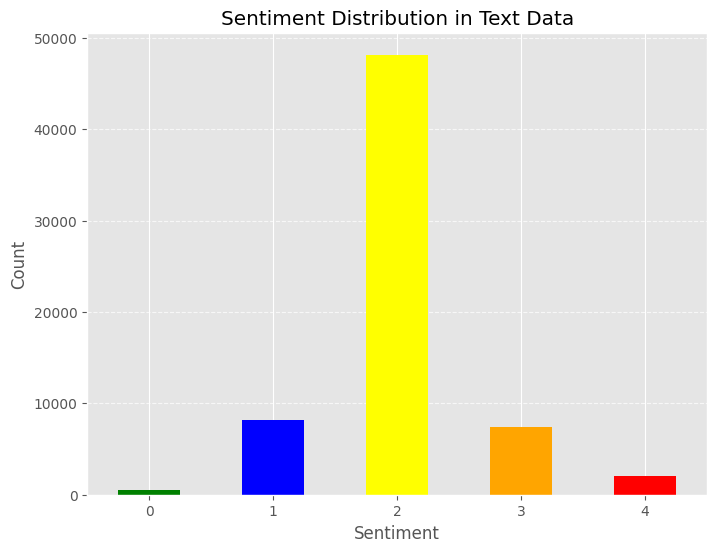

In [23]:
# Calculate sentiment counts
sentiment_counts = test['Predicted_Sentiment'].value_counts()

# Ensure the sentiment scores are in order from 0 to 4
# Assuming sentiment scores range from 0 to 4
sentiment_counts = sentiment_counts.reindex([0, 1, 2, 3, 4], fill_value=0)

# Create a bar chart
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=['green', 'blue', 'yellow', 'orange', 'red'])
plt.title('Sentiment Distribution in Text Data')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


In [24]:
# Save to CSV
output.to_csv('test_predictions1.csv', index=False)